<a href="https://colab.research.google.com/github/Simple2006/gun_det/blob/main/gundetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from sklearn.model_selection import train_test_split
from PIL import Image
import gdown
from IPython import display
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16, 
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet', 
                                            include_top = False, 
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable
    
  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'], 
                optimizer = optimizers.SGD(lr=nn_params['learning_rate'], momentum=nn_params['momentum']), 
                metrics=['accuracy'])

  return expert_model

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 2))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([0, 1])
    if label == 1:
      final_labels[i,:] = np.array([1, 0])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry. 
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
  ax.legend(loc = 1)    
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')
  
  plt.show()

# neural net parameters
image_shape          = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 2
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import cv2
import os
import numpy as np

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            new_height = 32
            new_width = 32
            dsize = (new_width, new_height)
            resized = cv2.resize(img, dsize)
            images.append(resized)
    return images
folder="/content/drive/MyDrive/data/guns"
bfolder="/content/drive/MyDrive/data/not guns"

In [10]:
pictures = load_images_from_folder(folder)

In [11]:
backgroundpictures = load_images_from_folder(bfolder)

In [12]:
totalpictures = []
totalpictures.append(pictures)
totalpictures.append(backgroundpictures)
new_total = []
#new_size = (32, 32, 3)
#for image in totalpictures:
#  a = np.reshape(image, new_size)
#  new_total.append(a)
totalStack = np.stack(totalpictures)
print(np.shape(totalpictures))
print(np.shape(totalStack))

(2, 100, 32, 32, 3)
(2, 100, 32, 32, 3)


In [13]:
normalizedX = normalize(np.array(totalpictures))
onesG = np.ones((100), dtype=int)
zerosNG = np.zeros((100), dtype=int)

In [14]:
labels = []
labels.append(onesG)
labels.append(zerosNG)
#print(np.shape(labels))
print(nn_params["output_neurons"])

2


In [15]:
X_train, X_test, y_train, y_test = train_test_split(totalpictures, labels, test_size=0.33, random_state=42)
print(np.shape(X_train))
print(y_test)
#print(X_train)

(1, 100, 32, 32, 3)
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


In [ ]:
'''my_size = (100, 32, 32, 3)
my_size1 = (100,)
X_train = np.reshape(X_train, my_size)
X_test = np.reshape(X_test, my_size)
y_train = np.reshape(y_train, my_size1)
y_test = np.reshape(y_test, my_size1)
y_train = label_to_onehot(y_train)
y_test = label_to_onehot(y_test)
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))
transfer = TransferClassifier(name = "VGG16")
transfer.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), shuffle = True)'''

(100, 32, 32, 3)
(100, 32, 32, 3)
(1, 100)
(1, 100)
Epoch 1/100
4/4 [==============================] - 1s 125ms/step - loss: 27.2483 - accuracy: 0.5565 - val_loss: 1.4521 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 58ms/step - loss: 2.7819 - accuracy: 0.7104 - val_loss: 1.0956 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 46ms/step - loss: 0.8541 - accuracy: 0.7755 - val_loss: 0.9790 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 43ms/step - loss: 0.5092 - accuracy: 0.8982 - val_loss: 4.3813 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 43ms/step - loss: 1.6482 - accuracy: 0.8707 - val_loss: 7.7341 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 43ms/step - loss: 1.7493 - accuracy: 0.9015 - val_loss: 1.5742 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 42ms/step - loss: 0.3423 - a

array([[9.9979538e-01, 8.9996721e-04],
       [9.9988425e-01, 5.6241179e-04],
       [9.9996114e-01, 2.2826607e-04],
       [9.9997318e-01, 1.6828955e-04],
       [9.9968541e-01, 1.2832290e-03],
       [9.9985588e-01, 6.7391008e-04],
       [9.9999213e-01, 6.1147126e-05],
       [9.9988735e-01, 5.4983865e-04],
       [9.9973577e-01, 1.1109717e-03],
       [9.9991465e-01, 4.3763488e-04],
       [9.9991274e-01, 4.4543363e-04],
       [9.9993086e-01, 3.6772434e-04],
       [9.9996614e-01, 2.0372165e-04],
       [9.9993312e-01, 3.5772132e-04],
       [9.9979204e-01, 9.1193931e-04],
       [9.9991000e-01, 4.5710980e-04],
       [9.9989426e-01, 5.2217033e-04],
       [9.9993443e-01, 3.5178792e-04],
       [9.9995816e-01, 2.4264080e-04],
       [9.9990928e-01, 4.5975685e-04],
       [9.9994028e-01, 3.2593077e-04],
       [9.9999940e-01, 7.6397364e-06],
       [9.9999428e-01, 4.7139245e-05],
       [9.9994111e-01, 3.2225673e-04],
       [9.9986601e-01, 6.3467171e-04],
       [9.9979550e-01, 8.

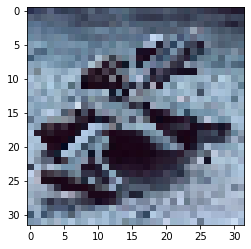

In [77]:
my_size = (100, 32, 32, 3)
my_size1 = (100,)
new_X_train = []
new_X_test = []

new_X_train = np.reshape(X_train, my_size)
new_X_test = np.reshape(X_test, my_size)
#new_X_train = np.stack(new_X_train)
plt.imshow(new_X_train[1])
print(np.shape(new_X_train))
print(np.shape(new_X_test))
print(np.shape(y_train))
print(np.shape(y_test))

y_train = np.reshape(y_train, my_size1)
y_test = np.reshape(y_test, my_size1)
y_train = label_to_onehot(y_train)
y_test = label_to_onehot(y_test)
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
vgg_model = Sequential()
vgg_model.add(vgg_expert)
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.9))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.9))
vgg_model.add(Dense(2, activation = 'sigmoid'))
#
vgg_model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.95),
    metrics = ["accuracy"]
)
vgg_model.fit(new_X_train, y_train, epochs = 100, validation_data = (new_X_test, y_test), shuffle = True)
vgg_model.predict(new_X_test)

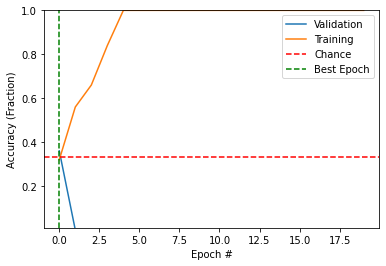

In [62]:
plot_acc(vgg_model.history)